<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_2_deep_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
#install GluonTS
!pip install --upgrade mxnet~=1.7 gluonts

In [ ]:
#metatrader 5 history file any timeframe is ok
df = pd.read_csv('/content/EURUSD_H1_200001030000_202202031200.csv')


In [ ]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [ ]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,2000.01.03,00:00:00,1.00730,1.01320,1.00730,1.01280,194,0,50
1,2000.01.03,01:00:00,1.01290,1.01410,1.01200,1.01370,113,0,50
2,2000.01.03,02:00:00,1.01400,1.01730,1.01340,1.01710,149,0,50
3,2000.01.03,03:00:00,1.01700,1.01900,1.01700,1.01750,214,0,50
4,2000.01.03,04:00:00,1.01730,1.01770,1.01640,1.01670,162,0,50
...,...,...,...,...,...,...,...,...,...
137126,2022.02.03,08:00:00,1.13007,1.13013,1.12905,1.12914,1540,0,0
137127,2022.02.03,09:00:00,1.12913,1.12976,1.12881,1.12973,2556,0,0
137128,2022.02.03,10:00:00,1.12974,1.13026,1.12884,1.12952,4072,0,0
137129,2022.02.03,11:00:00,1.12953,1.12971,1.12839,1.12842,3394,0,0


In [ ]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                 0         1        5
0       2000.01.03  00:00:00  1.01280
1       2000.01.03  01:00:00  1.01370
2       2000.01.03  02:00:00  1.01710
3       2000.01.03  03:00:00  1.01750
4       2000.01.03  04:00:00  1.01670
...            ...       ...      ...
137126  2022.02.03  08:00:00  1.12914
137127  2022.02.03  09:00:00  1.12973
137128  2022.02.03  10:00:00  1.12952
137129  2022.02.03  11:00:00  1.12842
137130  2022.02.03  12:00:00  1.12793

[137131 rows x 3 columns]


In [ ]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [ ]:
new_df = new_df.rename(columns={5:'price'})

In [ ]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2000-01-03 00:00:00  1.01280
2000-01-03 01:00:00  1.01370
2000-01-03 02:00:00  1.01710
2000-01-03 03:00:00  1.01750
2000-01-03 04:00:00  1.01670
...                      ...
2022-02-03 08:00:00  1.12914
2022-02-03 09:00:00  1.12973
2022-02-03 10:00:00  1.12952
2022-02-03 11:00:00  1.12842
2022-02-03 12:00:00  1.12793

[137131 rows x 1 columns]


In [ ]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137131 entries, 2000-01-03 00:00:00 to 2022-02-03 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   137131 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


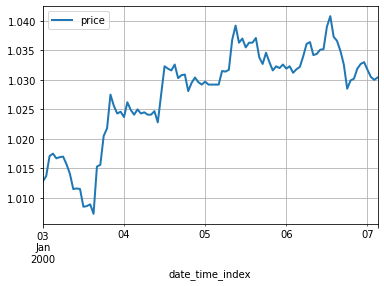

In [ ]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [ ]:
#import Gluon
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [66]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2021-01-01 00:00:00":"2022-02-03 00:00:00"]}], 
    freq = "1H"
    )

In [ ]:
#import model 
from gluonts.model.deepar import DeepAREstimator

from gluonts.model.deep_factor._network import DeepFactorPredictionNetwork, DeepFactorTrainingNetwork
from gluonts.model.deep_factor.RNNModel import RNNModel

from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.mx.trainer import Trainer

In [ ]:
#train model
estimator = DeepFactorEstimator(freq="1H", prediction_length=24, batch_size=24, num_hidden_global=1000,num_layers_global=10, trainer=Trainer(epochs=10, num_batches_per_epoch=10))
#estimator = DeepFactorEstimator(freq="1H", prediction_length=24, trainer=Trainer())

predictor = estimator.train(training_data=training_data)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
 10%|█         | 1/10 [00:18<02:48, 18.72s/it, epoch=1/10, avg_epoch_loss=0.632]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
 20%|██        | 2/10 [00:18<01:14,  9.35s/it, epoch=5/10, avg_epoch_loss=0.347]

In [75]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-02-03 00:00:00"]}],
    freq = "1H"
)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


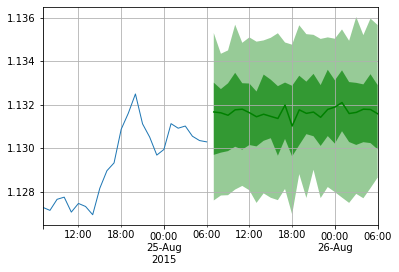

In [76]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-24:].plot(linewidth=1)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 120
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


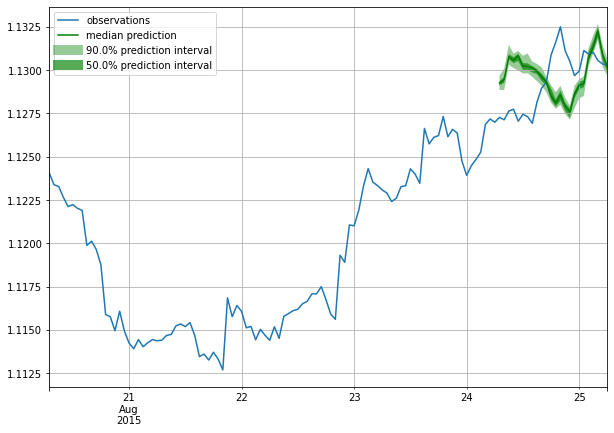

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=24,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])